# Monografia version en jupyter

In [8]:
#monografia - Modelo predictivo para la clasificacion si una persona renueva o no (Continua o no)

# debo reemplazar dataset porque no esta la imputacion de los null de genero y el cambio de municipio en el codigo. para la practica se dejara asi

#Se extrajo un dataset o un archivo de csv desde la DIAN para identificar el tipo de zona geografia (Urbano y rural)
#  para agrupar la ubicacion de los titulares
# Mediante analitica de texto con diccionario de nombres se realizo la imputacion de los null en la variable de genero


                            #al extraer coloque null igual a 0       
#======================Librerias para manipular=====================
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
#from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


In [9]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot

In [10]:
#===============DATASET============================
# los datos para el modelo: recueda no hemos sacado la muestra.
ruta_archivo ="C:\\Users\\lrebolledo\\Documents\\Monografia\\Base_Monografia.csv"
df  = pd.read_csv(ruta_archivo, delimiter=';')
print(df.head())  # Verificar lo que se monto
print(f"Total registros: {len(df)}")

df = df.dropna ()

         Canal  Poliza_Grupal  Id_Titular  Contrato     Estado Genero  \
0  Corporativo            109    98489820    372459     Renovo      M   
1  Corporativo            109  1023560816    372461     Renovo      F   
2    Asociadas            678  1193533406    372475  No Renovo      M   
3    Asociadas            678  1017270607    372476  No Renovo      M   
4    Asociadas            678  1152466412    372477  No Renovo      F   

   Edad_Titular Ingreso_Titular Municipio Tipo_Municipio  ...  \
0          59.0       1/01/2023  Medellín         Urbano  ...   
1           3.0       1/01/2023  Medellín         Urbano  ...   
2          23.0       1/01/2023  Medellín         Urbano  ...   
3          25.0       1/01/2023  Medellín         Urbano  ...   
4          26.0       1/01/2023  Medellín         Urbano  ...   

   Valor_Contratos_activos_anteriores  Casado  Beneficiario  Mascotas  \
0                                   0       0             0         0   
1                       

In [11]:
#=====Exploracion de DATASET y sus variables===================================
print(df.info())
#Lista de variables categóricas
catCols = df.select_dtypes(include = ["object", 'category']).columns.tolist()
#Se elimina la columna estado de la lista de variables Categóricas ya que es nuestra variable de salida
catCols.remove('Estado')
catCols.remove('Municipio')#Se elimina para el analisis de variables categoricos
catCols.remove('Id_Titular')#Se elimina para el analisis de variables categoricos
catCols.remove('Ingreso_Titular')#Se elimina para el analisis de variables categoricos
catCols.remove('Fecha_Renovacion_Actual')#Se elimina para el analisis de variables categoricos
#print(df[catCols].head(2))



<class 'pandas.core.frame.DataFrame'>
Index: 56932 entries, 0 to 57460
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               56932 non-null  object 
 1   Poliza_Grupal                       56932 non-null  int64  
 2   Id_Titular                          56932 non-null  object 
 3   Contrato                            56932 non-null  int64  
 4   Estado                              56932 non-null  object 
 5   Genero                              56932 non-null  object 
 6   Edad_Titular                        56932 non-null  float64
 7   Ingreso_Titular                     56932 non-null  object 
 8   Municipio                           56932 non-null  object 
 9   Tipo_Municipio                      56932 non-null  object 
 10  Forma_pago                          56932 non-null  int64  
 11  Vigencia_del_contrato               56932 non-

In [12]:
#Lista de variables numéricas
numCols=df.select_dtypes(include = ['int64']).columns.tolist()
numCols.remove('Poliza_Grupal')#Se elimina para el analisis de variables categoricos
numCols.remove('Contrato')#Se elimina para el analisis de variables categoricos
print(df[numCols].head(2))

   Forma_pago  Vigencia_del_contrato  Numero_de_pagos  Valor_Pagado  \
0          30                    360                0             0   
1          30                    360                0             0   

   periocidad_cambiante  Numero_recompras_o_renovacion  \
0                     1                              5   
1                     1                              5   

   Contratos_activos_anteriores  Valor_Contratos_activos_anteriores  Casado  \
0                             0                                   0       0   
1                             0                                   0       0   

   Beneficiario  Mascotas  Exequial_Personas  Auxilio  Asistencia_Personas  \
0             0         0                  1        1                    0   
1             0         0                  1        1                    0   

   Total_prima_mes  PQRS  Comunicación  
0                0     0             0  
1                0     0             0  


In [13]:
print(df[numCols].info())

<class 'pandas.core.frame.DataFrame'>
Index: 56932 entries, 0 to 57460
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Forma_pago                          56932 non-null  int64
 1   Vigencia_del_contrato               56932 non-null  int64
 2   Numero_de_pagos                     56932 non-null  int64
 3   Valor_Pagado                        56932 non-null  int64
 4   periocidad_cambiante                56932 non-null  int64
 5   Numero_recompras_o_renovacion       56932 non-null  int64
 6   Contratos_activos_anteriores        56932 non-null  int64
 7   Valor_Contratos_activos_anteriores  56932 non-null  int64
 8   Casado                              56932 non-null  int64
 9   Beneficiario                        56932 non-null  int64
 10  Mascotas                            56932 non-null  int64
 11  Exequial_Personas                   56932 non-null  int64
 12  Auxilio  

In [14]:
print(df[catCols].info())
#print(df[numCols].Info())

<class 'pandas.core.frame.DataFrame'>
Index: 56932 entries, 0 to 57460
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Canal           56932 non-null  object
 1   Genero          56932 non-null  object
 2   Tipo_Municipio  56932 non-null  object
 3   Metodo_Pago     56932 non-null  object
dtypes: object(4)
memory usage: 2.2+ MB
None


In [15]:
#==========================para evaluar========================
# Distribución de cada variable categórica en el conjunto de datos

#for col in catCols:
 #  print("="*5 + f" {col} " + "="*20)
  # print(df[col].value_counts())
   #print()
#De aqui se evidencia como reorganizar como los metodos de pago. Unificarlos en 3 (PAGO EN CAJA, FACTURA{FACTURA, CONVENIO,CUENTA DE COBRO}, PSE{DEBITO,DESCUENTO DE NOMINA,TARJETA DE CREDITO})


#VARIABLE DE SALIDA
print(df.groupby('Estado').Estado.count().sort_values(ascending=False))


Estado
Renovo       37061
No Renovo    19871
Name: Estado, dtype: int64


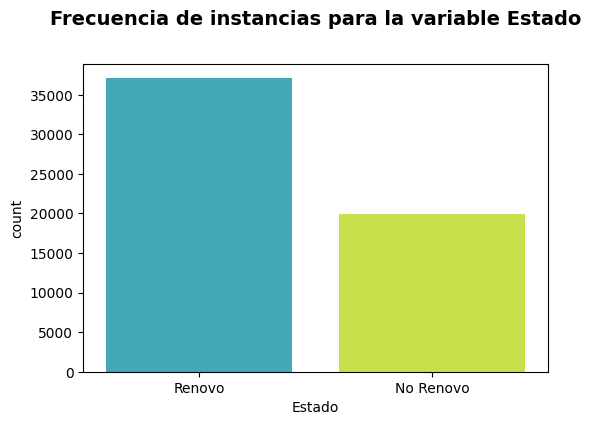

In [16]:
multiple_plot(1, df , None, 'Estado', 'countplot', 'Frecuencia de instancias para la variable Estado',0)

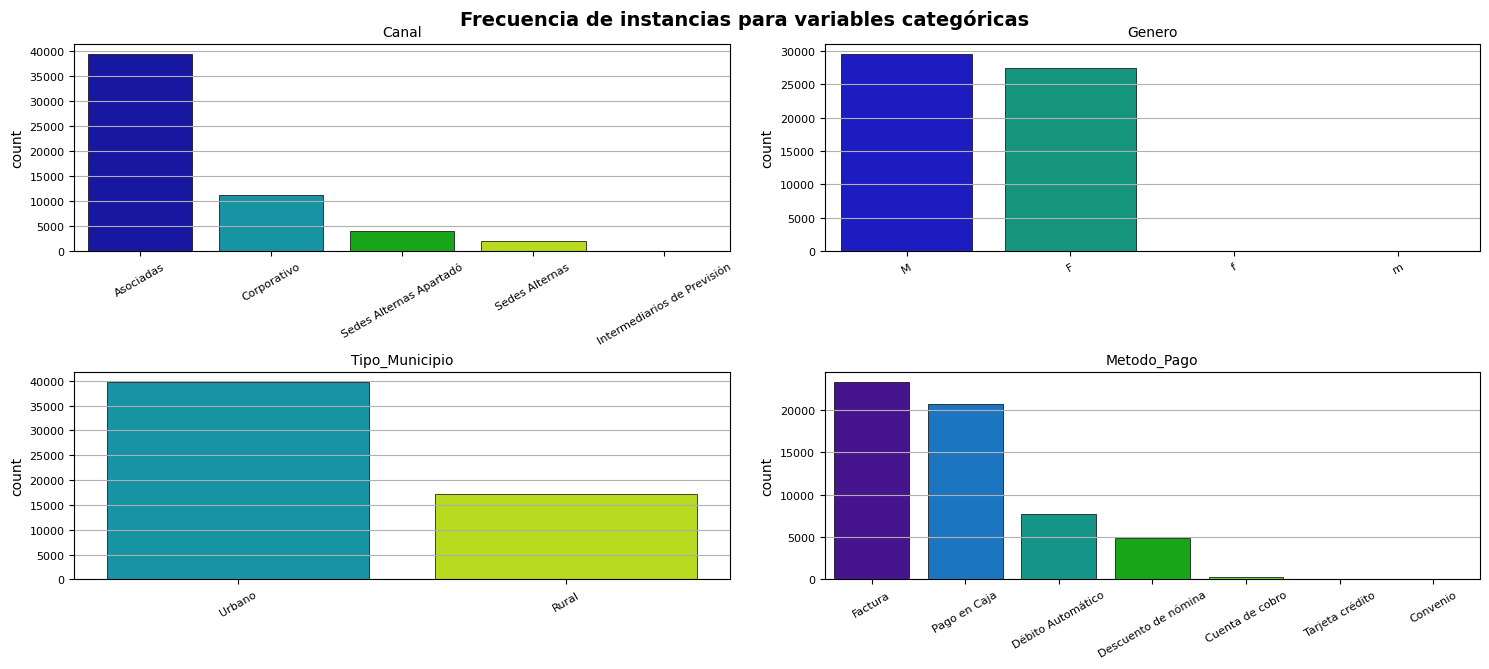

In [17]:
#Visualización de frecuencia de instancias para variables categóricas
multiple_plot(2, df , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [18]:
#Cambios en la data 

# Cambiar 'sex' de 'M' y 'F' a 1 y 0
df['Genero'] = df['Genero'].replace({'M': 1, 'F': 0,'m': 1, 'f': 0}).astype(int)
df['Tipo_Municipio'] = df['Tipo_Municipio'].replace({'Urbano': 1, 'Rural': 0}).astype(int)
df['Metodo_Pago'] = df['Metodo_Pago'].replace({'Factura': 1, 'Cuenta de cobro': 1,'Convenio': 1,'Pago en Caja': 0,'Débito Automático': 2,'Descuento de nómina': 2,'Tarjeta crédito': 2}).astype(int)

for col in catCols:
   print("="*5 + f" {col} " + "="*20)
   print(df[col].value_counts())
   print()

 

===== Canal ====================
Canal
Asociadas                      39475
Corporativo                    11245
Sedes Alternas Apartadó         4028
Sedes Alternas                  2070
Intermediarios de Previsión      114
Name: count, dtype: int64

===== Genero ====================
Genero
1    29555
0    27377
Name: count, dtype: int64

===== Tipo_Municipio ====================
Tipo_Municipio
1    39742
0    17190
Name: count, dtype: int64

===== Metodo_Pago ====================
Metodo_Pago
1    23550
0    20726
2    12656
Name: count, dtype: int64



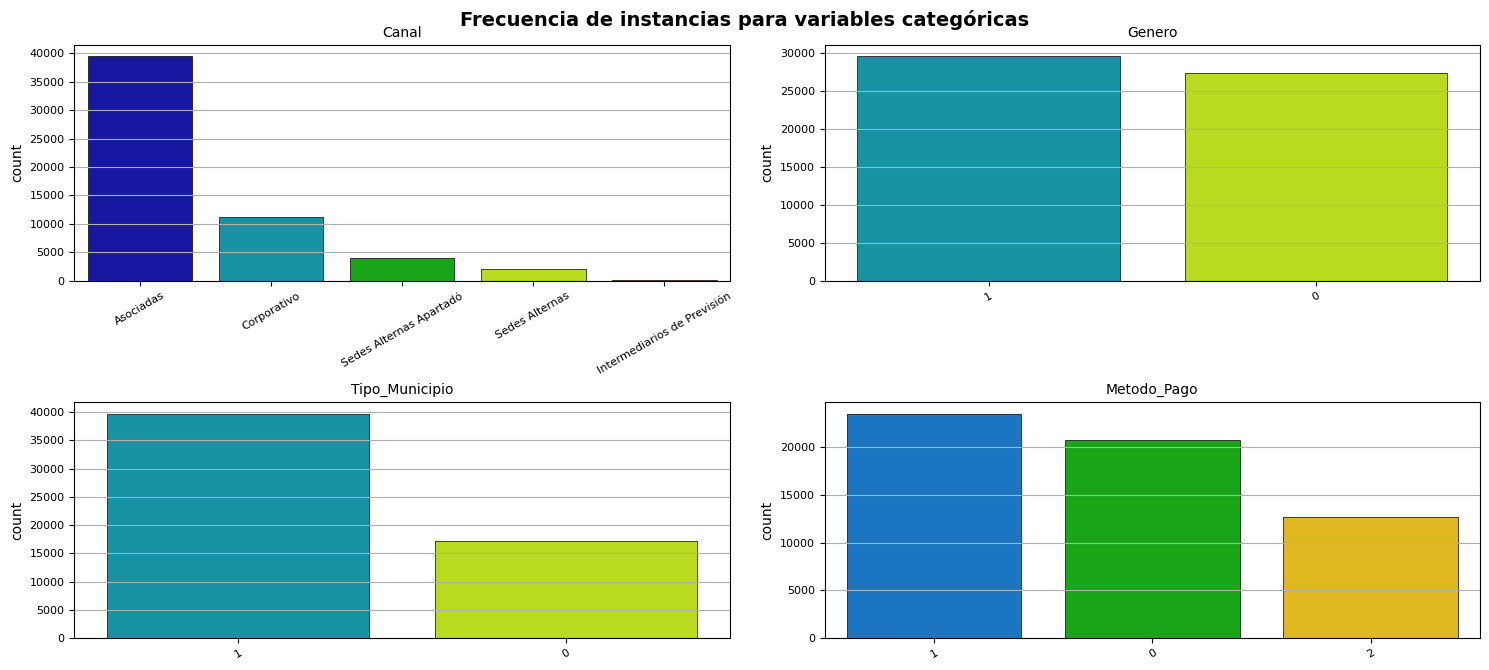

In [19]:
#Visualización de frecuencia de instancias para variables categóricas
multiple_plot(2, df , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [20]:
# Distribución de cada variable categórica en el conjunto de datos

for col in catCols:
    print("="*5 + f" {col} " + "="*20)
    print(df[col].value_counts())
    print()

===== Canal ====================
Canal
Asociadas                      39475
Corporativo                    11245
Sedes Alternas Apartadó         4028
Sedes Alternas                  2070
Intermediarios de Previsión      114
Name: count, dtype: int64

===== Genero ====================
Genero
1    29555
0    27377
Name: count, dtype: int64

===== Tipo_Municipio ====================
Tipo_Municipio
1    39742
0    17190
Name: count, dtype: int64

===== Metodo_Pago ====================
Metodo_Pago
1    23550
0    20726
2    12656
Name: count, dtype: int64



In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(numCols)

param_grid = {'n_neighbors': [5, 10, 15, 20, 25]}
lof = LocalOutlierFactor()

grid_search = GridSearchCV(lof, param_grid, cv=5, scoring='f1_micro')
grid_search.fit(X_scaled)  # Donde X es tu conjunto de datos
print("Mejor número de vecinos:", grid_search.best_params_)


ValueError: could not convert string to float: 'Forma_pago'

In [ ]:
#Primero eliminar outliers y null


#Visualización de variables numéricas
multiple_plot(1, df , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

### imputaciones

In [ ]:
# Identificación de valores nulos para las variables numéricas
for col in df[numCols]:
    print (col, np.sum(pd.isnull(df[col])))

In [ ]:
# Identificación de valores nulos para las variables categóricas
for col in df[catCols]:
    print (col, np.sum(pd.isnull(df[col])))